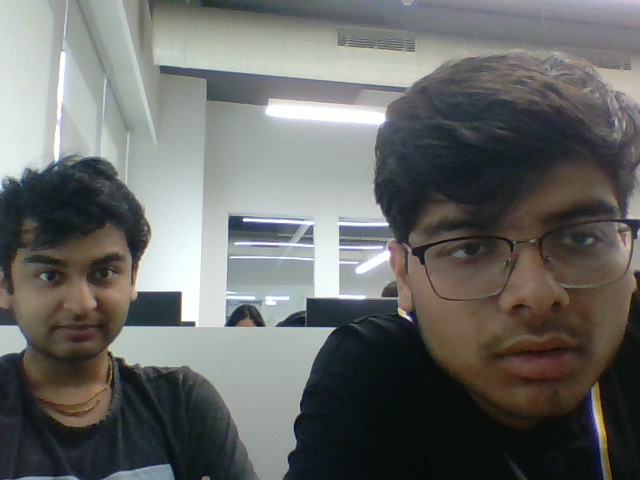

KeyboardInterrupt: 

In [5]:
# %% [markdown]
"""
# Advanced Hand Gesture + Age-Gender Recognition System
"""

# %% [markdown]
"""
## Requirements
- Python 3.7+
- OpenCV
- MediaPipe
- Jupyter Notebook
- Pre-trained age and gender models
"""

# %%
# Import required libraries
import cv2
import mediapipe as mp
import math
from IPython.display import display, clear_output
from PIL import Image
import numpy as np

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Load pre-trained age and gender models
age_net = cv2.dnn.readNetFromCaffe('age_deploy.prototxt', 'age_net.caffemodel')
gender_net = cv2.dnn.readNetFromCaffe('gender_deploy.prototxt', 'gender_net.caffemodel')

# Lists for age and gender labels
AGE_LIST = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
GENDER_LIST = ['Male', 'Female']

# Load Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# %%
def predict_age_gender(face_img):
    """
    Predict the age and gender of a cropped face image.
    """
    blob = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227),
                                 (78.4263377603, 87.7689143744, 114.895847746),
                                 swapRB=False)
    
    gender_net.setInput(blob)
    gender_preds = gender_net.forward()
    gender = GENDER_LIST[gender_preds[0].argmax()]
    
    age_net.setInput(blob)
    age_preds = age_net.forward()
    age = AGE_LIST[age_preds[0].argmax()]
    
    return gender, age

# %%
def recognize_gesture(hand_landmarks):
    """
    Recognize hand gesture based on finger extension.
    """
    thumb_tip = hand_landmarks.landmark[4]
    index_tip = hand_landmarks.landmark[8]
    middle_tip = hand_landmarks.landmark[12]
    ring_tip = hand_landmarks.landmark[16]
    pinky_tip = hand_landmarks.landmark[20]
    
    thumb_mcp = hand_landmarks.landmark[2]
    index_mcp = hand_landmarks.landmark[5]
    middle_mcp = hand_landmarks.landmark[9]
    ring_mcp = hand_landmarks.landmark[13]
    pinky_mcp = hand_landmarks.landmark[17]
    
    def is_finger_extended(tip, mcp, threshold=0.1):
        return tip.y < mcp.y - threshold
    
    thumb_extended = is_finger_extended(thumb_tip, thumb_mcp)
    index_extended = is_finger_extended(index_tip, index_mcp)
    middle_extended = is_finger_extended(middle_tip, middle_mcp)
    ring_extended = is_finger_extended(ring_tip, ring_mcp)
    pinky_extended = is_finger_extended(pinky_tip, pinky_mcp)
    
    fingers_extended = [thumb_extended, index_extended, middle_extended, ring_extended, pinky_extended]
    extended_count = sum(fingers_extended)
    
    if extended_count == 0:
        return "Fist"
    if thumb_extended and not any(fingers_extended[1:]):
        return "Thumbs Up"
    if index_extended and middle_extended and not any([thumb_extended, ring_extended, pinky_extended]):
        return "Victory"
    
    thumb_index_dist = math.sqrt((thumb_tip.x - index_tip.x)**2 + (thumb_tip.y - index_tip.y)**2)
    if thumb_index_dist < 0.05 and not middle_extended and not ring_extended and pinky_extended:
        return "OK"
    if index_extended and pinky_extended and not middle_extended and not ring_extended:
        return "Rock On"
    if index_extended and not any([thumb_extended, middle_extended, ring_extended, pinky_extended]):
        return "Pointing"
    if all(fingers_extended):
        return "Open Hand"
    if thumb_extended and index_extended and pinky_extended and not middle_extended and not ring_extended:
        return "Horns"
    if thumb_extended and index_extended and middle_extended and not ring_extended and not pinky_extended:
        return "Spider-Man"
    
    return "Unknown"

# %%
def draw_hand_landmarks(frame, hand_landmarks):
    """
    Draw landmarks and connections on the hand.
    """
    for landmark in hand_landmarks.landmark:
        x, y = int(landmark.x * frame.shape[1]), int(landmark.y * frame.shape[0])
        cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)
    
    mp_drawing.draw_landmarks(
        frame,
        hand_landmarks,
        mp_hands.HAND_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(121, 22, 76)),
        mp_drawing.DrawingSpec(color=(250, 44, 250))
    )

# %%
def main():
    """
    Main function for real-time gesture + age-gender recognition.
    """
    hands = mp_hands.Hands(
        min_detection_confidence=0.7,
        min_tracking_confidence=0.7,
        max_num_hands=2
    )
    
    cap = cv2.VideoCapture(0)
    
    try:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)
            
            gesture = "Unknown"
            
            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    draw_hand_landmarks(frame, hand_landmarks)
                    gesture = recognize_gesture(hand_landmarks)
                    
                    # Display gesture
                    cv2.putText(
                        frame, gesture, (10, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 2,
                        (0, 255, 0), 3, cv2.LINE_AA
                    )
                    
            # If Open Hand detected -> run face detection + age-gender
            if gesture == "Pointing":
                gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.3, 5)

                for (x, y, w, h) in faces:
                    face_img = frame[y:y+h, x:x+w]
                    gender, age = predict_age_gender(face_img)

                    label = f"{gender}, {age}"
                    cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
                    cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 255), 2, cv2.LINE_AA)
            
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            clear_output(wait=True)
            display(Image.fromarray(frame))
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
                
    finally:
        cap.release()
        cv2.destroyAllWindows()

# %%
if __name__ == "__main__":
    print("Starting Hand Gesture + Age-Gender Recognition...")
    main()


In [8]:
import cv2
import mediapipe as mp
import math
import numpy as np
import os
from datetime import datetime

# Load Age-Gender Models
age_net = cv2.dnn.readNetFromCaffe('age_deploy.prototxt', 'age_net.caffemodel')
gender_net = cv2.dnn.readNetFromCaffe('gender_deploy.prototxt', 'gender_net.caffemodel')

AGE_BUCKETS = ['(0-2)', '(4-6)', '(8-12)', '(15-20)', '(25-32)', '(38-43)', '(48-53)', '(60-100)']
GENDER_BUCKETS = ['Male', 'Female']

# Initialize Mediapipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7)

# Two Cameras
cap_gesture = cv2.VideoCapture(0)  # Hand Gesture camera
# cap_face = cv2.VideoCapture(1)     # Face Detection camera

# Face Detection using HaarCascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def recognize_gesture(hand_landmarks):
    # Same as your earlier recognize_gesture() function
    thumb_tip = hand_landmarks.landmark[4]
    index_tip = hand_landmarks.landmark[8]
    middle_tip = hand_landmarks.landmark[12]
    ring_tip = hand_landmarks.landmark[16]
    pinky_tip = hand_landmarks.landmark[20]
    
    thumb_mcp = hand_landmarks.landmark[2]
    index_mcp = hand_landmarks.landmark[5]
    middle_mcp = hand_landmarks.landmark[9]
    ring_mcp = hand_landmarks.landmark[13]
    pinky_mcp = hand_landmarks.landmark[17]
    
    def is_finger_extended(tip, mcp, threshold=0.1):
        return tip.y < mcp.y - threshold
    
    fingers_extended = [
        is_finger_extended(thumb_tip, thumb_mcp),
        is_finger_extended(index_tip, index_mcp),
        is_finger_extended(middle_tip, middle_mcp),
        is_finger_extended(ring_tip, ring_mcp),
        is_finger_extended(pinky_tip, pinky_mcp)
    ]
    
    extended_count = sum(fingers_extended)
    
    if extended_count == 0:
        return "Fist"
    if fingers_extended[0] and not any(fingers_extended[1:]):
        return "Thumbs Up"
    if fingers_extended[1] and fingers_extended[2] and not any([fingers_extended[0], fingers_extended[3], fingers_extended[4]]):
        return "Victory"
    
    return "Unknown"

def detect_gender(frame):
    # Detect face
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    if len(faces) == 0:
        return None, frame
    
    for (x, y, w, h) in faces:
        face_img = frame[y:y+h, x:x+w]
        blob = cv2.dnn.blobFromImage(face_img, 1.0, (227, 227), (78.426, 87.768, 114.896), swapRB=False)
        
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()
        gender = GENDER_BUCKETS[gender_preds[0].argmax()]
        
        label = f"{gender}"
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,0,0), 2)
        
        return gender, frame
    
    return None, frame

while True:
    ret1, frame_gesture = cap_gesture.read()
    ret2, frame_face = cap_face.read()
    
    if not ret1 or not ret2:
        print("Camera feed failed.")
        break
    
    # Gesture Detection
    rgb_frame = cv2.cvtColor(frame_gesture, cv2.COLOR_BGR2RGB)
    results = hands.process(rgb_frame)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            gesture = recognize_gesture(hand_landmarks)
            if gesture in ["Victory", "Thumbs Up"]:
                print(f"Gesture Detected: {gesture}")
                
                # Detect Gender
                gender, annotated_frame = detect_gender(frame_face.copy())
                if gender:
                    # Save Screenshot
                    filename = datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{gender}.png"
                    cv2.imwrite(filename, annotated_frame)
                    print(f"Saved screenshot: {filename} | Gender: {gender}")
                else:
                    print("No face detected.")
                
    # Display Gesture camera
    cv2.imshow('Gesture Camera', frame_gesture)
    # Display Face camera
    cv2.imshow('Face Camera', frame_face)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap_gesture.release()
cap_face.release()
cv2.destroyAllWindows()


Camera feed failed.


In [10]:
import streamlit as st
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image
import time

# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Initialize Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to recognize gestures
def recognize_gesture(hand_landmarks):
    thumb_tip = hand_landmarks.landmark[4]
    index_tip = hand_landmarks.landmark[8]
    middle_tip = hand_landmarks.landmark[12]
    ring_tip = hand_landmarks.landmark[16]
    pinky_tip = hand_landmarks.landmark[20]

    thumb_mcp = hand_landmarks.landmark[2]
    index_mcp = hand_landmarks.landmark[5]
    middle_mcp = hand_landmarks.landmark[9]
    ring_mcp = hand_landmarks.landmark[13]
    pinky_mcp = hand_landmarks.landmark[17]

    def is_finger_extended(tip, mcp, threshold=0.1):
        return tip.y < mcp.y - threshold

    thumb_extended = is_finger_extended(thumb_tip, thumb_mcp)
    index_extended = is_finger_extended(index_tip, index_mcp)
    middle_extended = is_finger_extended(middle_tip, middle_mcp)
    ring_extended = is_finger_extended(ring_tip, ring_mcp)
    pinky_extended = is_finger_extended(pinky_tip, pinky_mcp)

    fingers_extended = [thumb_extended, index_extended, middle_extended, ring_extended, pinky_extended]
    extended_count = sum(fingers_extended)

    if extended_count == 0:
        return "Fist"
    if thumb_extended and not any(fingers_extended[1:]):
        return "Thumbs Up"
    if index_extended and middle_extended and not any([thumb_extended, ring_extended, pinky_extended]):
        return "Victory"
    if index_extended and not any([thumb_extended, middle_extended, ring_extended, pinky_extended]):
        return "Pointing"
    if all(fingers_extended):
        return "Open Hand"
    return "Unknown"

# Function to detect faces
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

# Streamlit App
st.title("🖐️ Hand Gesture & Face Recognition App")

st.sidebar.title("Camera Selection")
camera_type = st.sidebar.selectbox("Select Camera Type:", ["Laptop Webcam", "IP Camera"])

if camera_type == "Laptop Webcam":
    camera_index = 0
    ip_url = None
else:
    ip_url = st.sidebar.text_input("Enter IP Camera URL (e.g., http://192.168.0.101:8080/video):")
    camera_index = ip_url if ip_url else 0

run = st.checkbox('Run')
FRAME_WINDOW = st.image([])

if run:
    cap = cv2.VideoCapture(camera_index)
    with mp_hands.Hands(min_detection_confidence=0.7, min_tracking_confidence=0.7, max_num_hands=2) as hands:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                st.write("Failed to capture image")
                break

            # Flip the image for a later selfie-view display
            frame = cv2.flip(frame, 1)
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = hands.process(rgb_frame)

            gesture_detected = False

            if results.multi_hand_landmarks:
                for hand_landmarks in results.multi_hand_landmarks:
                    mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
                    gesture = recognize_gesture(hand_landmarks)
                    cv2.putText(frame, gesture, (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

                    if gesture == "Victory":
                        gesture_detected = True

            if gesture_detected:
                # Save screenshot
                timestamp = time.strftime("%Y%m%d-%H%M%S")
                screenshot_path = f"screenshot_{timestamp}.png"
                cv2.imwrite(screenshot_path, frame)
                st.success(f"Gesture detected! Screenshot saved as {screenshot_path}")

                # Detect faces
                faces = detect_faces(frame)
                for (x, y, w, h) in faces:
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
                    face_img = frame[y:y+h, x:x+w]
                    st.image(cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB), caption="Detected Face")

            FRAME_WINDOW.image(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()


2025-04-29 03:30:32.226 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.523 
  command:

    streamlit run C:\Users\anush\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-04-29 03:30:32.526 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.528 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.530 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.531 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.532 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-29 03:30:32.533 Thre